# Decision Tree Classifier

## Load the Required Libraries

In [27]:
import os
import cv2
import numpy as np 
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import Parallel, delayed, dump
from tensorflow.keras.applications import VGG16
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.metrics import (
    accuracy_score, f1_score, cohen_kappa_score, recall_score, precision_score, confusion_matrix
)

## Load the Dataset

In [2]:
categories = [['benign',438],['malignant',211],['normal',134]]
path = "C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Canser/Dataset_BUSI_with_GT"

In [3]:
all_data_path_list = []

images_path_list= []
mask_path_list = []

for i in range(len(categories)) : 
    
    folder_path = (f'{path}/{categories[i][0]}')
    
    for j in range(1,categories[i][1]):
    
        image_path = (f'{folder_path}/{categories[i][0]} ({j}).png') 
        mask_path = (f'{folder_path}/{categories[i][0]} ({j})_mask.png') 
        
        images_path_list.append(image_path)
        mask_path_list.append(mask_path)
        
    data_path_df = pd.DataFrame()
    
    data_path_df['Image-Path'] =   images_path_list   
    data_path_df['Mask-Path'] = mask_path_list
    data_path_df['Label'] = categories[i][0]
    
    all_data_path_list.append(data_path_df)
    
    images_path_list = []
    mask_path_list = []
    
data_path_df = pd.concat(all_data_path_list,axis = 0)
data_path_df.reset_index(drop=True,inplace=True)

data_path_df

,Image-Path,Mask-Path,Label
0,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,benign
1,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,benign
2,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,benign
3,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,benign
4,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,benign
...,...,...,...
775,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,normal
776,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,normal
777,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,normal
778,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,normal


## Balance the Dataset

In [4]:
data_path_df['Label'].value_counts()

Label
benign       437
malignant    210
normal       133
Name: count, dtype: int64

In [5]:
min_samples = data_path_df['Label'].value_counts().min()
balanced_df = data_path_df.groupby('Label').sample(n=min_samples, replace=False).reset_index(drop=True)

shuffled_df = balanced_df.sample(frac=1).reset_index(drop=True)

In [26]:
map_dic = {'benign': 0, 'malignant': 1, 'normal': 2}
shuffled_df['Label'] = shuffled_df['Label'].replace(map_dic).astype(int)

In [7]:
print(shuffled_df['Label'].value_counts())

Label
0    133
1    133
2    133
Name: count, dtype: int64


In [8]:
shuffled_df = shuffled_df.sample(frac=1)
shuffled_df.reset_index(inplace = True,drop = True)

shuffled_df

,Image-Path,Mask-Path,Label
0,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,2
1,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,0
2,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,1
3,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,2
4,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,1
...,...,...,...
394,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,0
395,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,1
396,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,1
397,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,C:/Users/NaderZadeh/Desktop/UNI/MV/Breast Cans...,0


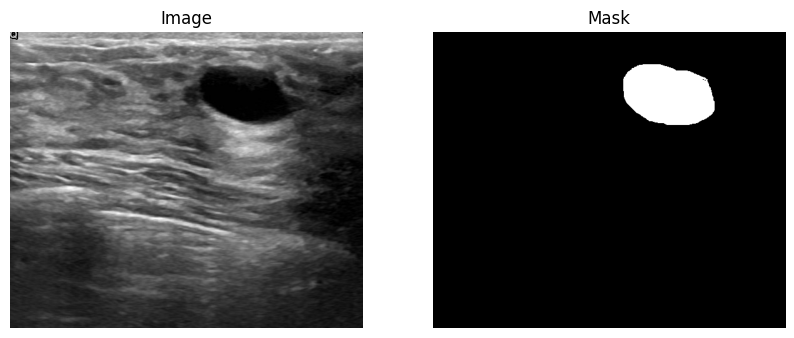

In [9]:
# random display

random_image = cv2.imread(shuffled_df['Image-Path'][100])
random_mask = cv2.imread(shuffled_df['Mask-Path'][100],cv2.IMREAD_GRAYSCALE)
random_sample = cv2.cvtColor(random_image, cv2.COLOR_BGR2RGB)

fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(random_sample)
axes[0].set_title('Image')
axes[0].axis('off')

axes[1].imshow(random_mask, cmap='gray')
axes[1].set_title('Mask')
axes[1].axis('off')

plt.show()

## Helper functions

### Load and resize an image

In [10]:
def load_image_and_mask(image_path, mask_path):
    try:
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
        if image is None:
            raise FileNotFoundError(f"Image not found at {image_path}")
        if mask is None:
            raise FileNotFoundError(f"Mask not found at {mask_path}")
        return image, mask
    except Exception as e:
        print(f"Error loading image or mask: {e}")
        return None, None

### Evaluation Function

In [11]:
evaluation_results = pd.DataFrame(columns=[
    'Classifier', 'Train Accuracy', 'Validation Accuracy', 'Test Accuracy',
    'F1 Score', 'Cohen Kappa', 'Recall', 'Precision'
])

In [12]:
def evaluate_model(y_true, y_pred, classifier_name, train_acc=None, val_acc=None, save_report=False, normalize=False):
    global evaluation_results

    conf_matrix = confusion_matrix(y_true=y_true, y_pred=y_pred, normalize='true' if normalize else None)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        conf_matrix, annot=True, fmt=".2f" if normalize else "d",
        cmap="Blues", cbar=False, linewidths=0.5, linecolor="gray"
    )
    plt.title(f"Confusion Matrix - {classifier_name}", fontsize=16)
    plt.xlabel("Predicted Label", fontsize=12)
    plt.ylabel("True Label", fontsize=12)
    plt.tight_layout()
    plt.show()

    test_acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred, average='weighted')
    kappa = cohen_kappa_score(y_true, y_pred)
    recall = recall_score(y_true, y_pred, average='weighted')
    precision = precision_score(y_true, y_pred, average='weighted')

    new_results = {
        'Classifier': classifier_name,
        'Train Accuracy': train_acc,
        'Validation Accuracy': val_acc,
        'Test Accuracy': test_acc,
        'F1 Score': f1,
        'Cohen Kappa': kappa,
        'Recall': recall,
        'Precision': precision
    }
    evaluation_results = pd.concat([evaluation_results, pd.DataFrame([new_results])], ignore_index=True)

    if save_report:
        evaluation_results.to_csv(f"{classifier_name}_evaluation_results.csv", index=False)

    print(f"\nEvaluation Metrics for {classifier_name}:\n")
    print(pd.DataFrame([new_results]))  # Display the latest evaluation result

## VGG (Visual Geometry Group) Feature Extraction

In [13]:
vgg_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [16]:
def vgg_feature_extractor(image, mask=None):
    try:
        # Apply mask if provided
        if mask is not None:
            image = cv2.bitwise_and(image, image, mask=mask.astype(np.uint8))
        # Preprocess the image for VGG16
        image = preprocess_input(image)
        image = np.expand_dims(image, axis=0)
        # Extract features using VGG16
        features = vgg_model.predict(image)
        return features.flatten()
    except Exception as e:
        print(f"Error extracting VGG features: {e}")
        return None

### Process a single row of the DataFrame to extract features and labels

In [17]:
def process_row(row):
    try:
        image_path = row['Image-Path']
        mask_path = row['Mask-Path']

        # Load and resize the image and mask
        image = cv2.imread(image_path)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if image is None:
            print(f"Failed to load image: {image_path}")
            return None, None
        if mask is None and row['Label'] != 2:  # For benign/malignant
            print(f"Failed to load mask: {mask_path}")
            return None, None

        # Resize image and mask to VGG16 input size
        image_resized = cv2.resize(image, (224, 224))
        if mask is not None:
            mask_resized = cv2.resize(mask, (224, 224))

        # Extract features
        if row['Label'] != 2:
            features = vgg_feature_extractor(image_resized, mask_resized)
        else:
            features = vgg_feature_extractor(image_resized)

        if features is None:
            print(f"Feature extraction failed for row: {row.name}")
            return None, None

        return features, row['Label']
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return None, None

## Train and Test split

In [20]:
results = Parallel(n_jobs=-1)(delayed(process_row)(row) for _, row in shuffled_df.iterrows())

X, Y = zip(*results)

X_filtered = [x for x in X if x is not None]
Y_filtered = [y for y, x in zip(Y, X) if x is not None]

X_filtered = np.array(X_filtered)
Y_filtered = np.array(Y_filtered)

print(f"Number of valid samples: {len(X_filtered)}")

Number of valid samples: 399


In [21]:
results = []
for idx, row in shuffled_df.iterrows():
    features, label = process_row(row)
    if features is not None:
        results.append((features, label))

print(f"Number of successfully processed rows: {len(results)}")

if len(results) == 0:
    raise ValueError("No valid samples after feature extraction. Check your dataset and preprocessing steps.")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 955ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 428ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 449ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 425ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 445ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 424ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 396ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 437ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 414ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 441ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 482ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 444ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 417ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 415ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 432ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 400ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

In [22]:
X_train, X_test, Y_train, Y_test = train_test_split(X_filtered, Y_filtered, test_size=0.2, random_state=0)

print(f"Training set shape: {X_train.shape}, {Y_train.shape}")
print(f"Testing set shape: {X_test.shape}, {Y_test.shape}")

Training set shape: (319, 25088), (319,)
Testing set shape: (80, 25088), (80,)


## Train the Decision Tree

In [23]:
dt_model = DecisionTreeClassifier(criterion='gini', max_depth=10, random_state=0)
dt_model.fit(X_train, Y_train)

train_accuracy = dt_model.score(X_train, Y_train)

### Make Predictions

In [24]:
# Predict on the test set
Y_pred = dt_model.predict(X_test)

## Evaluate the Model

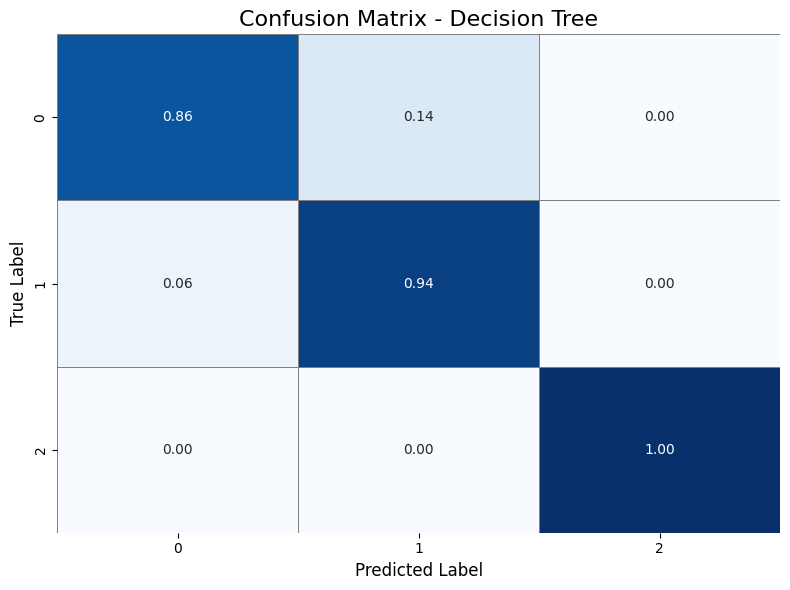


Evaluation Metrics for Decision Tree:

      Classifier  Train Accuracy Validation Accuracy  Test Accuracy  F1 Score  \
0  Decision Tree             1.0                None         0.9375  0.937191   

   Cohen Kappa  Recall  Precision  
0     0.903962  0.9375   0.937321  


C:\Users\NaderZadeh\AppData\Local\Temp\ipykernel_10864\340553670.py:33: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  evaluation_results = pd.concat([evaluation_results, pd.DataFrame([new_results])], ignore_index=True)


In [25]:
# Evaluate the Decision Tree model
evaluate_model(
    y_true=Y_test,
    y_pred=Y_pred,
    classifier_name="Decision Tree",
    train_acc=train_accuracy,
    val_acc=None,  # Add validation accuracy if applicable
    save_report=True,
    normalize=True  # Normalize confusion matrix
)

## Saving the Models (VGG and Decision Tree)

In [28]:
# Save the model
dump(dt_model, 'decision_tree_model.joblib')

# Save the VGG model
vgg_model.save('vgg16_model.h5')